<a href="https://colab.research.google.com/github/limesacul/IDLCV/blob/main/hotdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [5]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [6]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [2]:
import zipfile
import os

# Specify the path to the uploaded zip file (it will be in the current directory)
zip_file = 'hotdog_nothotdog.zip'  # Replace with the actual filename

# Create a directory to extract the files
extract_dir = '/content/hotdog_nothotdog'
os.makedirs(extract_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print(extracted_files)

['hotdog_nothotdog']


In [22]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/content/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [23]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [54]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        batch_images_count = images.size(0)
        images = images.view(batch_images_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_images_count

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [55]:
size = 128
basic_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=basic_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

mean, std = get_mean_std(train_loader)

train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)])

test_transform = train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)])

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data

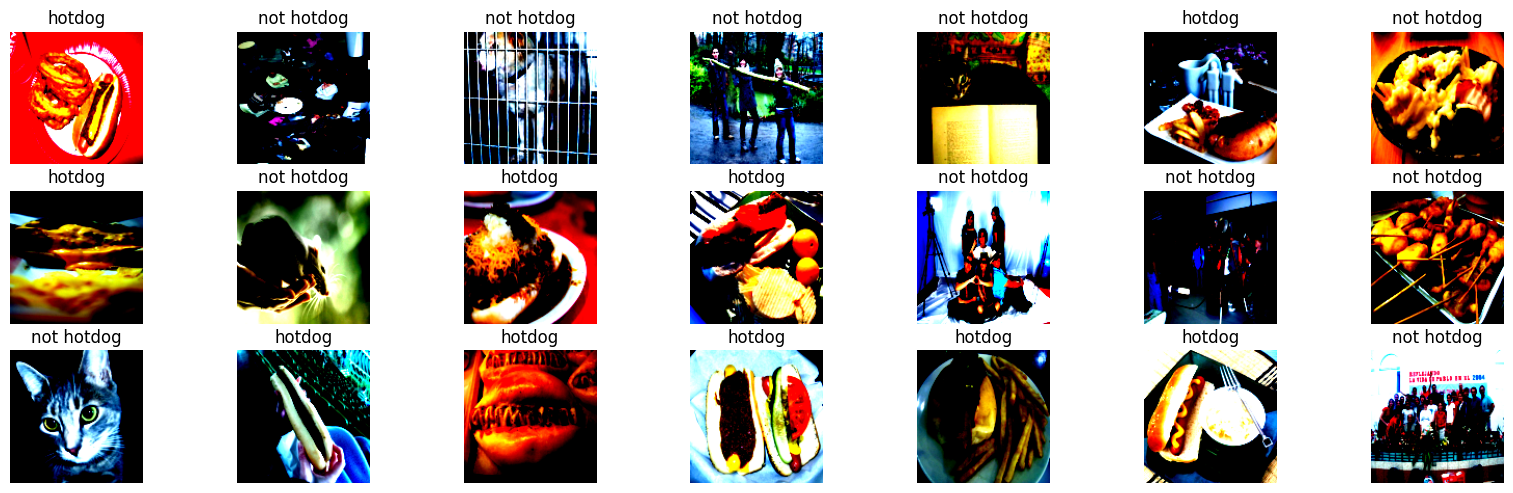

In [56]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [57]:
#We first define the network

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.efficient_net = models.efficient_net_b0(pretrained=True)
        num_ftrs = self.efficient_net.net.classifier[1].in_features

        self.convolutional = nn.Sequential(
        # First two convolutional layers with 8 feature maps, 3x3 kernel, stride=1, padding=1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

        # Max pooling layer 2x2
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

        # Max pooling layer 2x2
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Next two convolutional layers with 16 feature maps, 3x3 kernel, stride=1, padding=1
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

         # Max pooling layer 2x2


         # Max pooling layer 2x2
        nn.MaxPool2d(kernel_size=2, stride=2)
                )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*256, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
                nn.Softmax(dim=1))

    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [58]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters())

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 256, 16, 16])


In [60]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()

        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 77.8%	 test: 74.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 79.6%	 test: 75.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 80.8%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 81.4%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 82.3%	 test: 75.9%
